<a href="https://colab.research.google.com/github/zweiss22/gshs_analysis/blob/main/code/CS1_5_Figs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [147]:
import pandas as pd
from collections import Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from numpy import inf
from numbers import Number
from matplotlib.colors import LogNorm, Normalize


In [156]:
#Import pre-processed data
data = pd.read_csv('ppp_new_clusters_FINAL.csv', sep = ',')
#Identify the peak sequences from each cluster
peak_seqs = data.drop_duplicates('Cluster')
#RS1 is the starting sequence that was mutagenized
rs1 = 'GAATGCTGCCAACCGTGCGGGCTAATTGGCAGACTGAGCT'

Text(0.5, -7.277777777777782, 'Number of mutations from RS1')

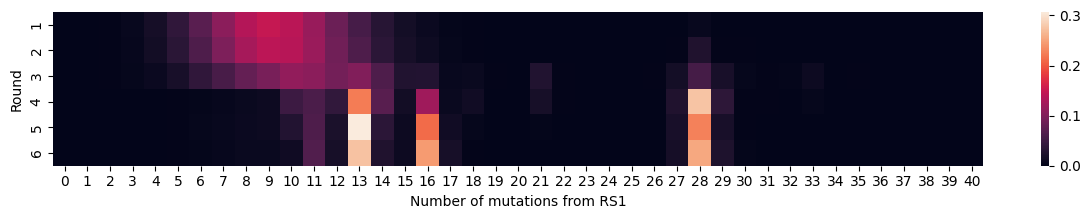

In [12]:
#Plot number of sequences each distance from RS1 for each round and plot heatmap
heatmap_mutation_data = []
for round in range(1,7):
    raw_seqs = open('Round'+str(round)+'_Correct_BPS_g1counts.txt').readlines()[1::2]
    counts = open('Round'+str(round)+'_Correct_BPS_g1counts.txt').readlines()[::2]

    seqs = []
    for i in range(len(counts)):
        seqs+=([raw_seqs[i]]*int(counts[i].split('>')[1]))

    distances = []
    for seq in seqs:
        distances.append(sum([1 for x, y in zip(rs1, seq) if x.lower() != y.lower()]))
    distances_counted = dict(Counter(distances))

    labels = [x[0] for x in list(distances_counted.items())]
    for i in list((set(labels)^set(range(41)))):
        distances_counted[i]=0
    mutations = [x[1] for x in sorted(distances_counted.items())]

    heatmap_mutation_data.append(np.array(mutations)/len(seqs))

plt.figure(figsize=(15,2))
yticklabels = range(1,7)
sns.heatmap(heatmap_mutation_data,yticklabels=yticklabels)
plt.ylabel('Round')
plt.xlabel('Number of mutations from RS1')


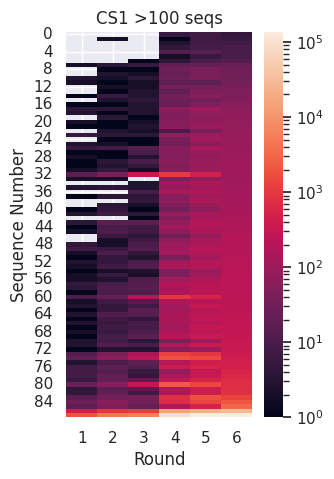

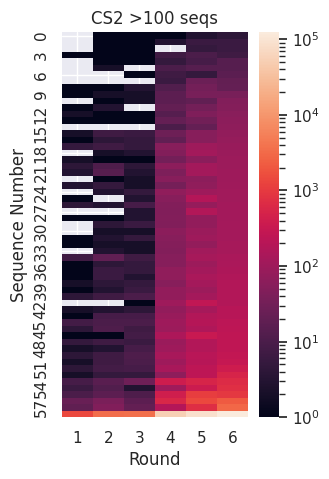

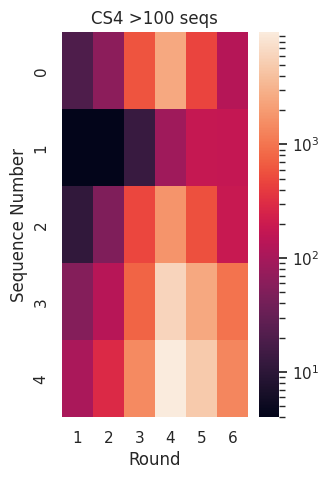

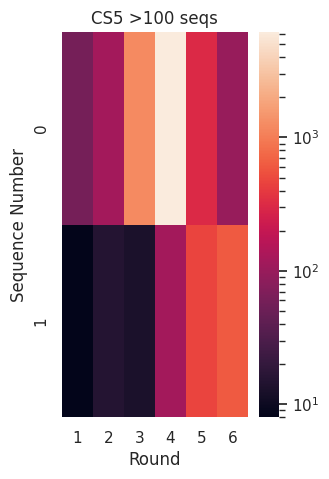

In [215]:
#Plot the abundance of the sequences with >n reads in a given cluster

def plot_cluster_greater_n(cs_index, n):
  seqs_in_cluster = data[data['Cluster']==data.loc[list(data['Seq']).index(list(peak_seqs['Seq'])[cs_index])][2]]
  gn_reads = seqs_in_cluster[seqs_in_cluster['Reads']>n]

  all_abundance = []
  for round in range(1,7):
      raw_seqs = open('Round'+str(round)+'_Correct_BPS_g1counts.txt').readlines()[1::2]
      counts = open('Round'+str(round)+'_Correct_BPS_g1counts.txt').readlines()[::2]

      abundance = []
      for seq in list(gn_reads['Seq']):
        if seq+'\n' in raw_seqs:
          abundance.append(int(counts[raw_seqs.index(seq+'\n')][1:]))
        else:
          abundance.append(0)
      all_abundance.append(abundance[::-1])

  sns.set()
  #sns.set(font_scale = 2.5)
  plt.figure(figsize=(3, 5))
  data_plot = np.array(all_abundance)
  max_val = 0
  min_val = 0
  for i in data_plot:
    if max(i)>max_val:
      max_val = max(i)
    if min(i)<min_val:
      min_val = min(i)
  hm = sns.heatmap(np.array(sorted(data_plot.T, key=lambda x: x[-1])),  cbar=True, linecolor='black', vmin = 0, vmax = np.round(max_val, 0)+1, norm=LogNorm(), xticklabels=range(1,7))

  plt.ylabel('Sequence Number')
  plt.xlabel('Round')
  plt.title('CS'+str(1+cs_index)+' >'+str(n)+' seqs')
  plt.show()

plot_cluster_greater_n(0, 100)
plot_cluster_greater_n(1, 100)
plot_cluster_greater_n(3, 100)
plot_cluster_greater_n(4, 100)

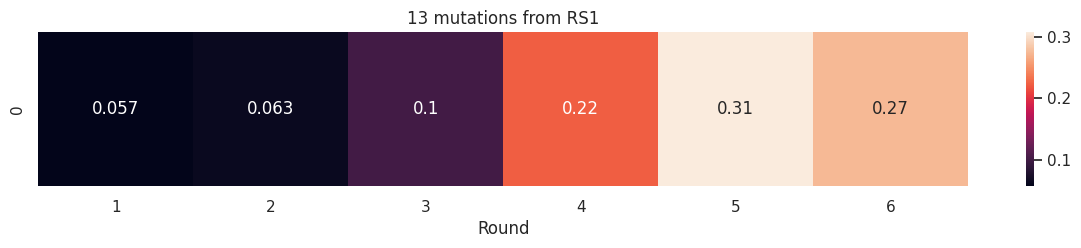

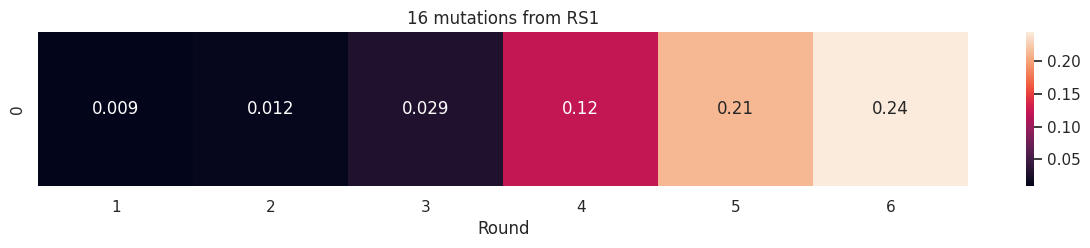

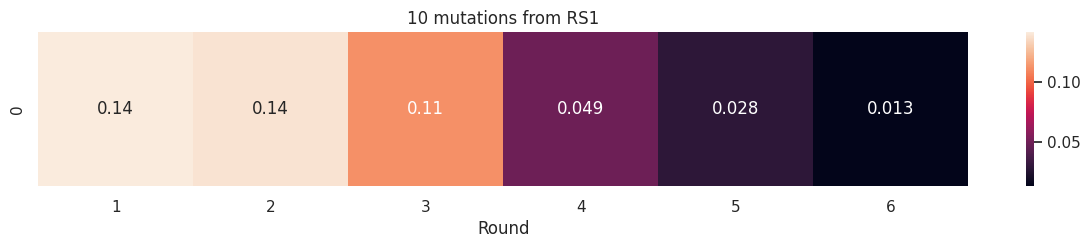

In [216]:
#Mutation heatmap by number of mutations from RSI
mutations_from_rs1 = 13

for mutations_from_rs1 in [13, 16, 10]:
    plt.figure(figsize=(15,2))
    xticklabels = range(1,7)
    sns.heatmap([np.array(heatmap_mutation_data).T[mutations_from_rs1]],xticklabels=xticklabels, annot=True)
    plt.xlabel('Round')
    plt.title(str(mutations_from_rs1)+' mutations from RS1')
    plt.show()

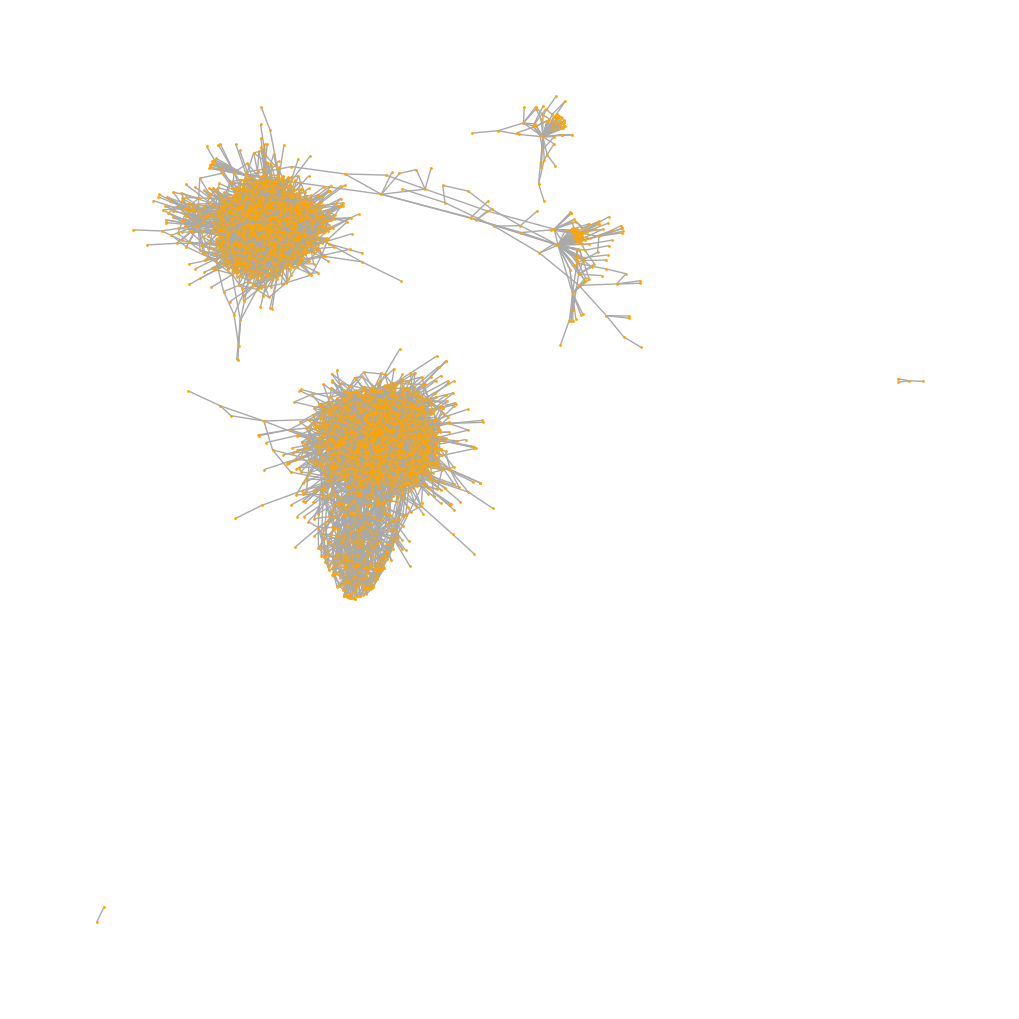

In [218]:
#Make adjacency matrix for all seqs within 10nt of CS1-5

#Keep only seqs with >n connections
def keep_seqs_with_n_connections(n, check, run_adjacent):
    seqs = list(data['Seq'])
    relevant_seqs = []
    for seq in seqs:
        for peak in check:
            if sum([1 for x, y in zip(seq, list(peak_seqs['Seq'])[peak]) if x.lower() != y.lower()])<n:
                relevant_seqs.append(seq)
                break
    if run_adjacent == True:
      adjacent = []
      print(len(relevant_seqs))

      for seq2 in range(len(relevant_seqs)):
          if seq2%100==0:
              print(seq2)
          seq_adjacent = []
          for seq1 in range(len(relevant_seqs)):
              if sum([1 for x, y in zip(relevant_seqs[seq2], relevant_seqs[seq1]) if x.lower() != y.lower()])==1:
                  seq_adjacent.append(1)
              else:
                  seq_adjacent.append(0)
          adjacent.append(seq_adjacent)
      np.savetxt('adjacency_matrix_'+str(n)+'_'+str(check)+'.csv', adjacent, delimiter=",")
    return relevant_seqs

#adjacent = keep_seqs_with_n_connections(15)
n = 5
check = [0,1,3,4]
relevant_seqs = keep_seqs_with_n_connections(n, check, False)

adjacent = pd.read_csv('adjacency_matrix_'+str(n)+'_'+str(check)+'.csv', sep = ',')
#adjacent = pd.DataFrame(adjacent)
row_sums = np.array(adjacent).sum(axis=1)
highly_connected = []
remove = []
for i in range(len(row_sums)):
    if row_sums[i] > 2:
        highly_connected.append(i)

to_plot = []
for i in highly_connected:
    to_plot.append(relevant_seqs[i])
len(to_plot)
labels = {}
G = nx.Graph()

#for i in range(len(to_plot)):
#    G.add_node(i)
#    for peak in check:
#        if to_plot[i]==list(peak_seqs['Seq'])[peak]:
#            labels[i] = 'CS'+str(peak+1)
for seq2 in range(len(to_plot)):
    for seq1 in range(len(to_plot)):
        if sum([1 for x, y in zip(to_plot[seq1], to_plot[seq2]) if x.lower() != y.lower()])==1:
            G.add_edge(seq1, seq2)
plt.figure(figsize=(10,10))
nx.draw(G, node_size=1, labels = labels, node_color = 'orange', edge_color = 'darkgrey')

In [219]:
n = 10
check = [0,3]
relevant_seqs = keep_seqs_with_n_connections(n, check, False)

adjacent = pd.read_csv('adjacency_matrix_'+str(n)+'_'+str(check)+'.csv', sep = ',')
#adjacent = pd.DataFrame(adjacent)


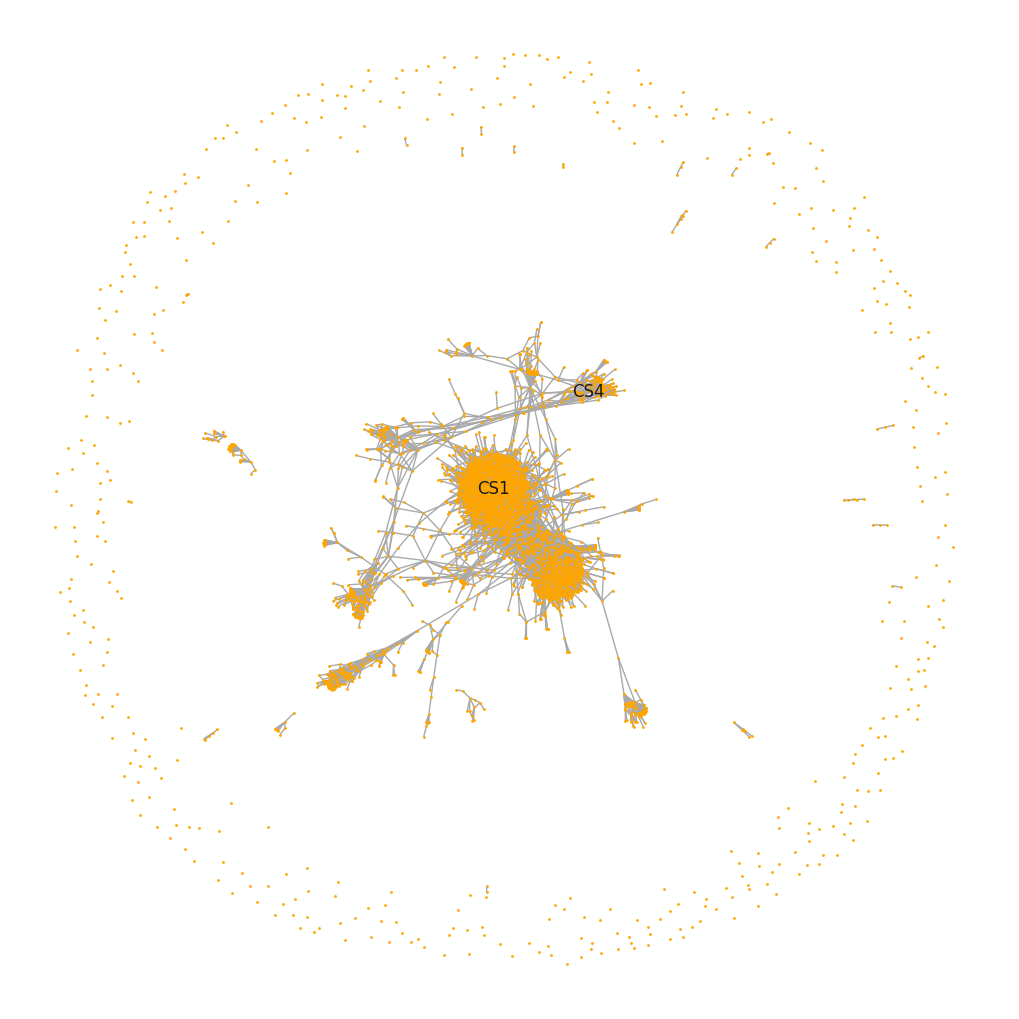

In [220]:
row_sums = np.array(adjacent).sum(axis=1)
highly_connected = []
remove = []
for i in range(len(row_sums)):
    if row_sums[i] > 0:
        highly_connected.append(i)

to_plot = []
for i in highly_connected:
    to_plot.append(relevant_seqs[i])
len(to_plot)
labels = {}
G = nx.Graph()

for i in range(len(to_plot)):
    G.add_node(i)
    for peak in check:
        if to_plot[i]==list(peak_seqs['Seq'])[peak]:
            labels[i] = 'CS'+str(peak+1)
for seq2 in range(len(to_plot)):
    for seq1 in range(len(to_plot)):
        if sum([1 for x, y in zip(to_plot[seq1], to_plot[seq2]) if x.lower() != y.lower()])==1:
            G.add_edge(seq1, seq2)
plt.figure(figsize=(10,10))
nx.draw(G, node_size=1, labels = labels, node_color = 'orange', edge_color = 'darkgrey')